In [1]:
import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as plticker
import mal_cfr_data.plot as mcd_plt
import mal_cfr_data.tournament as mcd_tournament

mcd_plt.set_plt_params(font_size=20)
div_color_palette = mcd_plt.diverging_color_palette()
seq_color_palette = mcd_plt.sequential_color_palette()

date = 'jan18_2021'

In [2]:
data = mcd_tournament.Data.load()
data.data

,game_tag,sampler,seed,mode,row_alg,col_alg,value,t
0,goofspiel_3p,null,None,fixed,CFR,CFR,-2.312960e-18,0
1,goofspiel_3p,null,None,fixed,CFR,CFR_EX+IN,-2.312960e-18,0
2,goofspiel_3p,null,None,fixed,CFR,CFR_IN,-2.312960e-18,0
3,goofspiel_3p,null,None,fixed,CFR,A-CFR_IN,-2.312960e-18,0
4,goofspiel_3p,null,None,fixed,CFR,BPS-CFR,-2.312960e-18,0
...,...,...,...,...,...,...,...,...
1011995,tiny_hanabi,null,None,fixed,BR,CSPS-CFR,1.000000e+01,499
1011996,tiny_hanabi,null,None,fixed,BR,CFPS-CFR,1.000000e+01,499
1011997,tiny_hanabi,null,None,fixed,BR,CFPS-CFR_EX+IN,8.000000e+00,499
1011998,tiny_hanabi,null,None,fixed,BR,TIPS-CFR_EX+IN,8.000000e+00,499


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


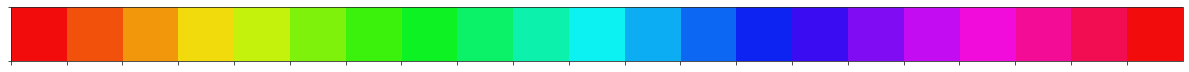

In [3]:
color_palettes = [colorsys.hls_to_rgb(f, 0.5, 0.9) for f in np.arange(0, 1.05, 0.05)]
print(np.arange(0, 1.05, 0.05))
sns.palplot(color_palettes)

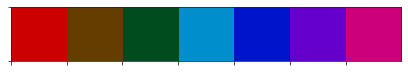

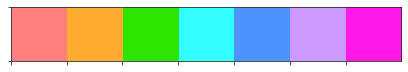

In [4]:
dark_hues = [0, 0.1, 0.4, 0.55, 0.65, 0.75, 0.9]
dark_lightness = [0.4, 0.2, 0.15, 0.4, 0.4, 0.4, 0.4]
light_hues = [1, 0.1, 0.3, 0.5, 0.6, 0.75, 0.85]
light_lightness = [0.75, 0.6, 0.45, 0.6, 0.65, 0.8, 0.55]
dark_colors = [colorsys.hls_to_rgb(h, dark_lightness[i], 1) for i, h in enumerate(dark_hues)]
sns.palplot(dark_colors)
light_colors = [colorsys.hls_to_rgb(h, light_lightness[i], 1) for i, h in enumerate(light_hues)]
sns.palplot(light_colors)

In [18]:
# Setting algorithm comparison groups
hsr_alg_comparisons = (('CFR', 'A-CFR_IN', 'CFR_IN', 'CFR_EX+IN'),)
rla_alg_comparisons = (
    ('CFR', 'A-CFR_IN', 'CFR_IN', 'CFR_EX+IN'),  # Weak algorithms
    ("BPS-CFR", "CFPS-CFR", "CSPS-CFR", 'TIPS-CFR', 'BEHAV-CFR'),  # PS algorithms
    ("CFPS-CFR", 'TIPS-CFR', "CFPS-CFR_EX+IN", 'TIPS-CFR_EX+IN'),  # PS alternatives
)
mike_alg_comparisons = (
    ('CFR', 'BPS-CFR', 'TIPS-CFR'),
)
nf_algs = ('CFR', 'CFR_IN', 'CFR_EX+IN')
alg_comparisons = rla_alg_comparisons
all_algs = set()
for alg_group in alg_comparisons:
    all_algs = all_algs.union({alg for alg in alg_group})
print(all_algs)

# Setup algorithm specific colors
cf_color_idx = 3
act_color_idx = 6
l1_ps_color_idx = 0
l2_ps_color_idx = 4
alg_color = {
    'CFR': dark_colors[cf_color_idx],
    'A-CFR_IN': dark_colors[act_color_idx],
    'CFR_IN': light_colors[cf_color_idx],
    "BPS-CFR": dark_colors[l1_ps_color_idx],
    "CFPS-CFR": light_colors[l1_ps_color_idx],
    "CSPS-CFR": dark_colors[l2_ps_color_idx],
    'TIPS-CFR': light_colors[l2_ps_color_idx],
    'BEHAV-CFR': (0, 0, 0),
    'CFR_EX+IN': dark_colors[2],
    "CFPS-CFR_EX+IN": dark_colors[1],
    'TIPS-CFR_EX+IN': dark_colors[5],
}
            
learning_curve_query_string = 'game_tag == "{game}" & mode == "{mode}"\
    & col_alg == {col_algs}\
    & row_alg == {algs}'

# Exclude algorithms not in any comparison group
data.data = data.data.query(f'col_alg == {list(all_algs)} & row_alg == {list(all_algs)}')


{'CFPS-CFR_EX+IN', 'TIPS-CFR', 'CFR', 'BPS-CFR', 'CFR_IN', 'CFR_EX+IN', 'A-CFR_IN', 'TIPS-CFR_EX+IN', 'CFPS-CFR', 'CSPS-CFR', 'BEHAV-CFR'}


In [38]:
def sharex_and_y_in_row(axes_list):
    shared_x = axes_list[0].get_shared_x_axes()
    shared_y = axes_list[0].get_shared_y_axes()
    for ax in axes_list[1:]:
        shared_x.join(axes_list[0], ax)
        shared_y.join(axes_list[0], ax)
        
def sharex_in_row(axes_list):
    for j, ax in enumerate(axes_list[1:]):
        axes_list[j - 1].sharex(ax)

def learning_curve_data(df, cumsum=True):
    df = df.pivot(index=['col_alg', 'row_alg'], columns='t', values='value')
    normalizer = 1.0
    if (cumsum):
        df = df.cumsum(axis=1)
        normalizer += df.columns.to_numpy()
    return (df.mean(level=1) / normalizer).T.sort_index(axis=1, key=mcd_tournament.alg_sort_keys)

def goofspiel_score_to_win_percentage(df):
    return (df + 1.) / 2.0 * 100

def is_goofspiel(game_tag):
    return game_tag[:len('goofspiel')] == 'goofspiel' or game_tag == 'random_goofspiel'

def is_leduc(game_tag):
    return game_tag == 'leduc'

def leduc_score_to_milli_antes(df):
    return df * 1000

avg_learning_curve_ylabel = r'avg.\ payoff'
inst_learning_curve_ylabel = 'payoff'

def leduc_learning_curve_config(df, ax, j, avg=True):
    if j == 0:
        ax.set_ylabel(
            fr'{avg_learning_curve_ylabel if avg else inst_learning_curve_ylabel} (mbb)')
    return leduc_score_to_milli_antes(df)

def goofspiel_learning_curve_config(df, ax, j, avg=True):
    if j == 0:
        ax.set_ylabel(r'avg.\ win \%' if avg else r'win \%')
    return goofspiel_score_to_win_percentage(df)

def learning_curve_figsize(games, alg_comparisons):
    return (5 + 1)/1.2 * len(alg_comparisons), 3.5/1.2 * len(games)

def learning_curves_adjust_spacing():
    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0.25, hspace=0.4)

def learning_curves_subplots(games, alg_comparisons):
    return plt.subplots(
        len(games),
        len(alg_comparisons),
        squeeze=False,
        figsize=learning_curve_figsize(games, alg_comparisons),
    #     gridspec_kw={'width_ratios': [0.25, 1, 1]}
    )

def learning_curves_legend(ax):
    ax.legend(
        ncol=2,
        fontsize='x-small',
        columnspacing=0.5,
        labelspacing=0.25,
        handletextpad=0.4,
        handlelength=0.5)

def learning_curves_set_ticks(ax):
    loc = plticker.MultipleLocator(base=100)
    ax.xaxis.set_major_locator(loc)
    start, end = ax.get_ylim()
    loc = plticker.MultipleLocator(base=(end - start) / 4.0)
    ax.yaxis.set_major_locator(loc)


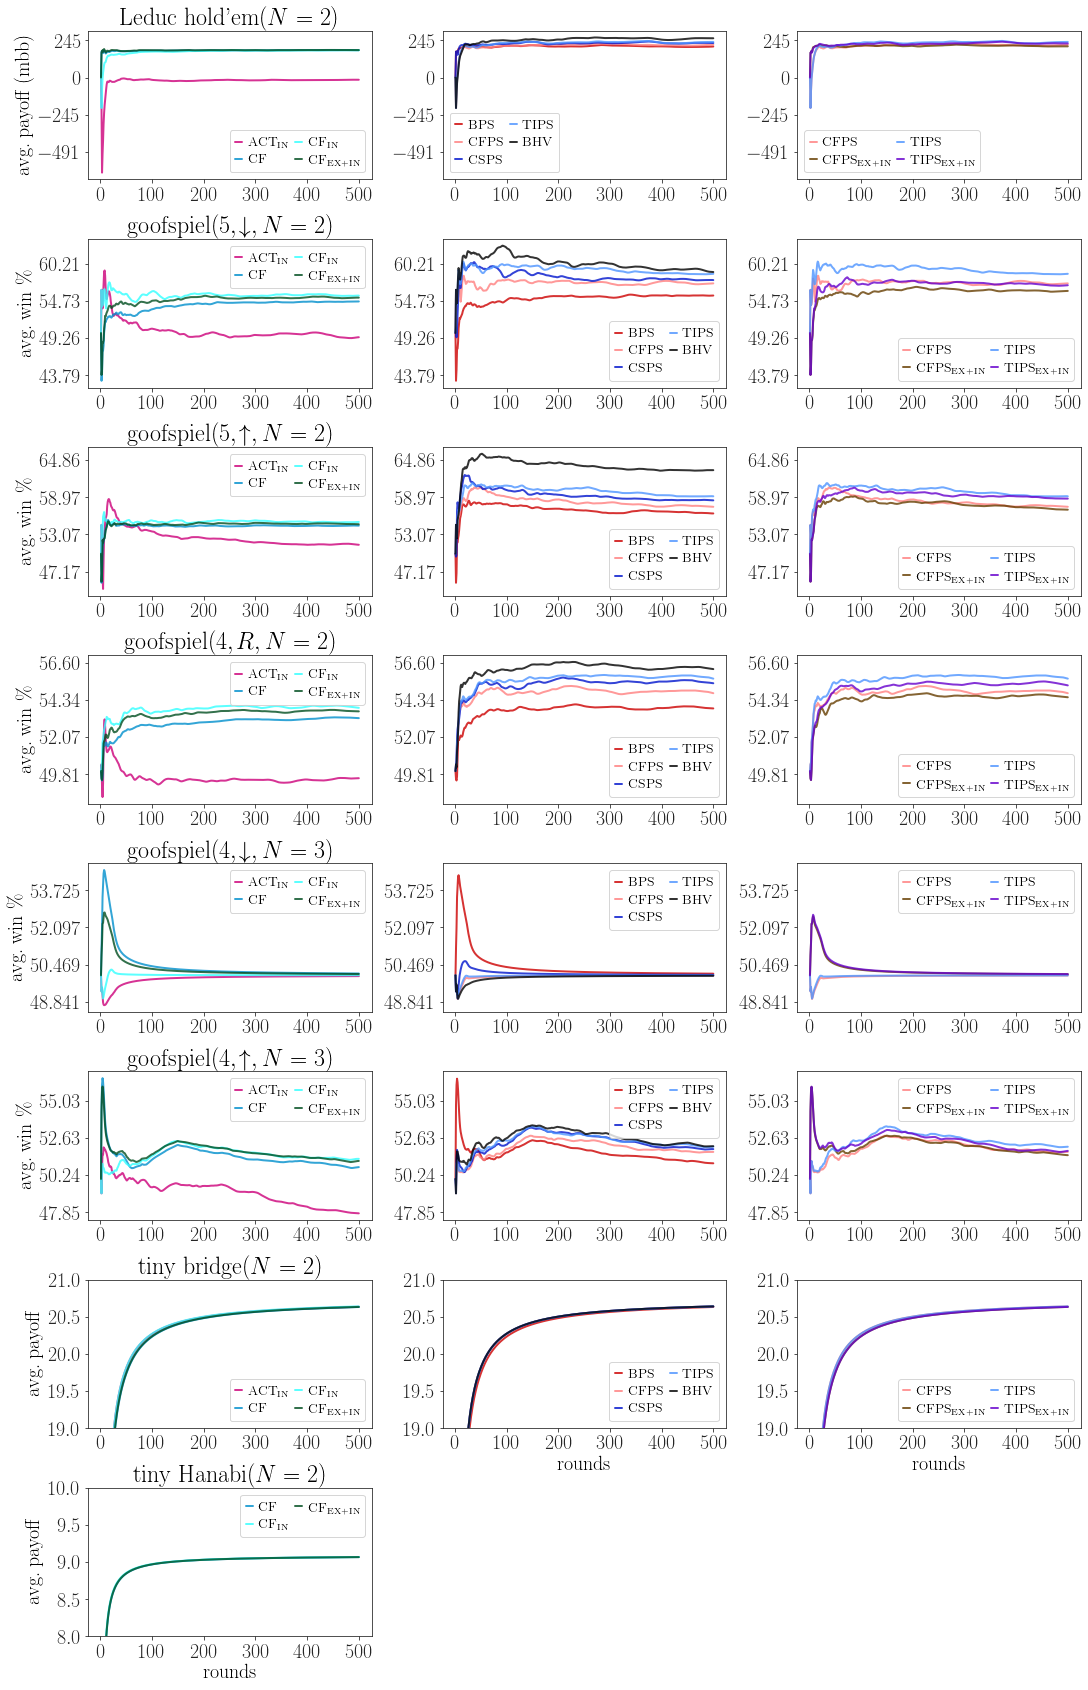

In [39]:
ylim_by_game = {
    'tiny_bridge': (19, 21),
    'tiny_hanabi': (8, 10),
}
games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='fixed',
                    algs=alg_group,
                    col_algs=list(all_algs))))
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j)
        elif j == 0:
            ax.set_ylabel(avg_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-2, 1:]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'results/learning_curves.fixed.{date}.pdf')

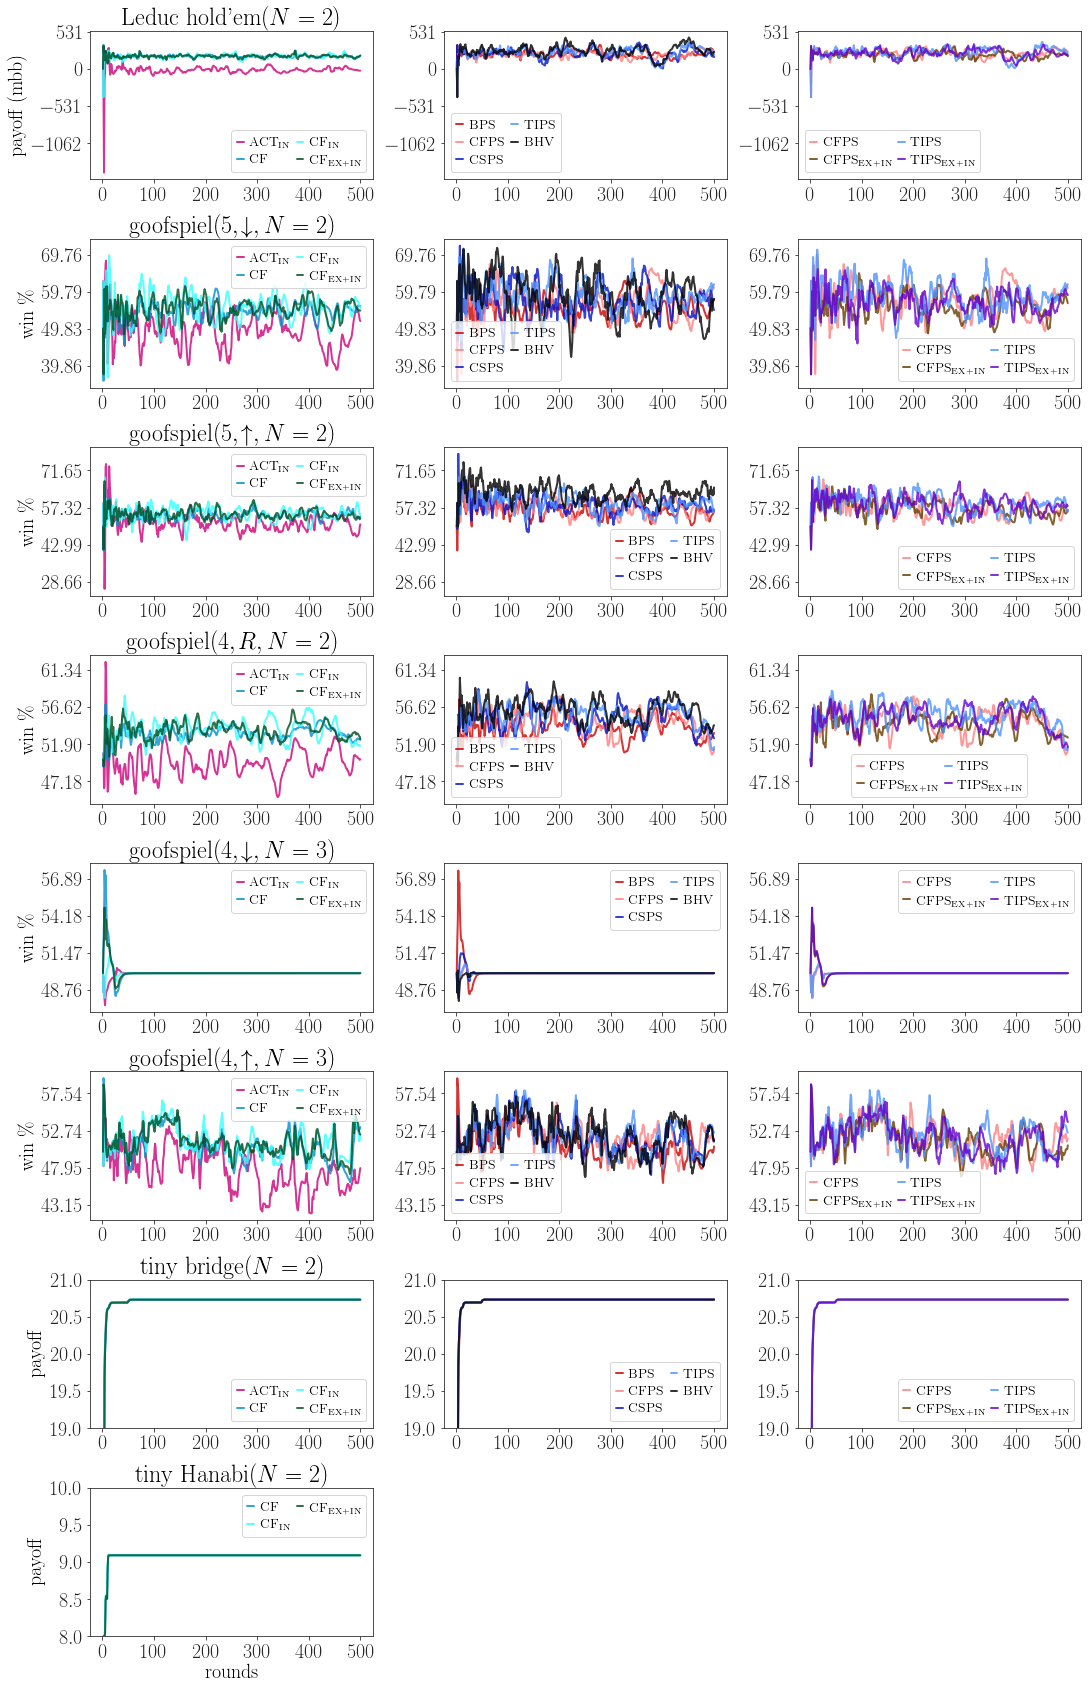

In [40]:
# ylim_by_game = {
# }

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='fixed',
                    algs=alg_group,
                    col_algs=list(all_algs))),
            False)
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j, avg=False)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j, avg=False)
        elif j == 0:
            ax.set_ylabel(inst_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'results/learning_curves.fixed.inst.{date}.pdf')

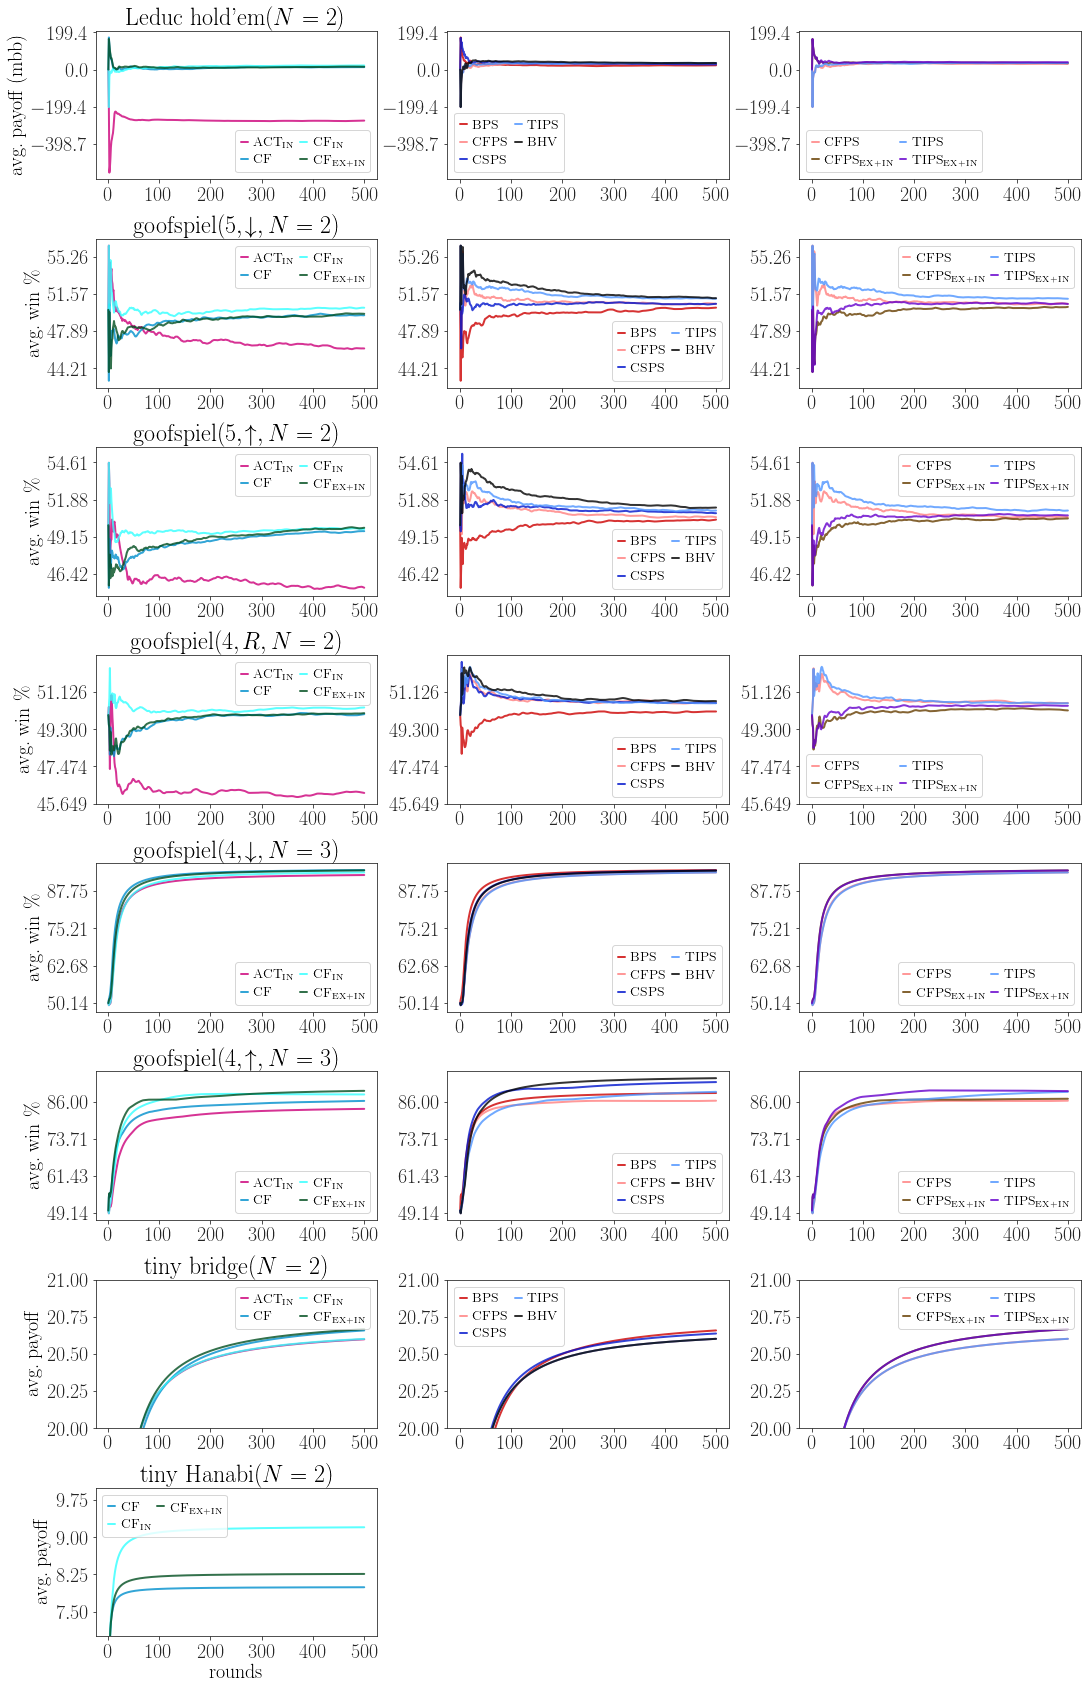

In [41]:
ylim_by_game = {
    'tiny_bridge': (20, 21),
    'tiny_hanabi': (7, 10),
}

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='sim',
                    algs=alg_group,
                    col_algs=list(all_algs))))
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j)
        elif j == 0:
            ax.set_ylabel(avg_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'results/learning_curves.sim.{date}.pdf')

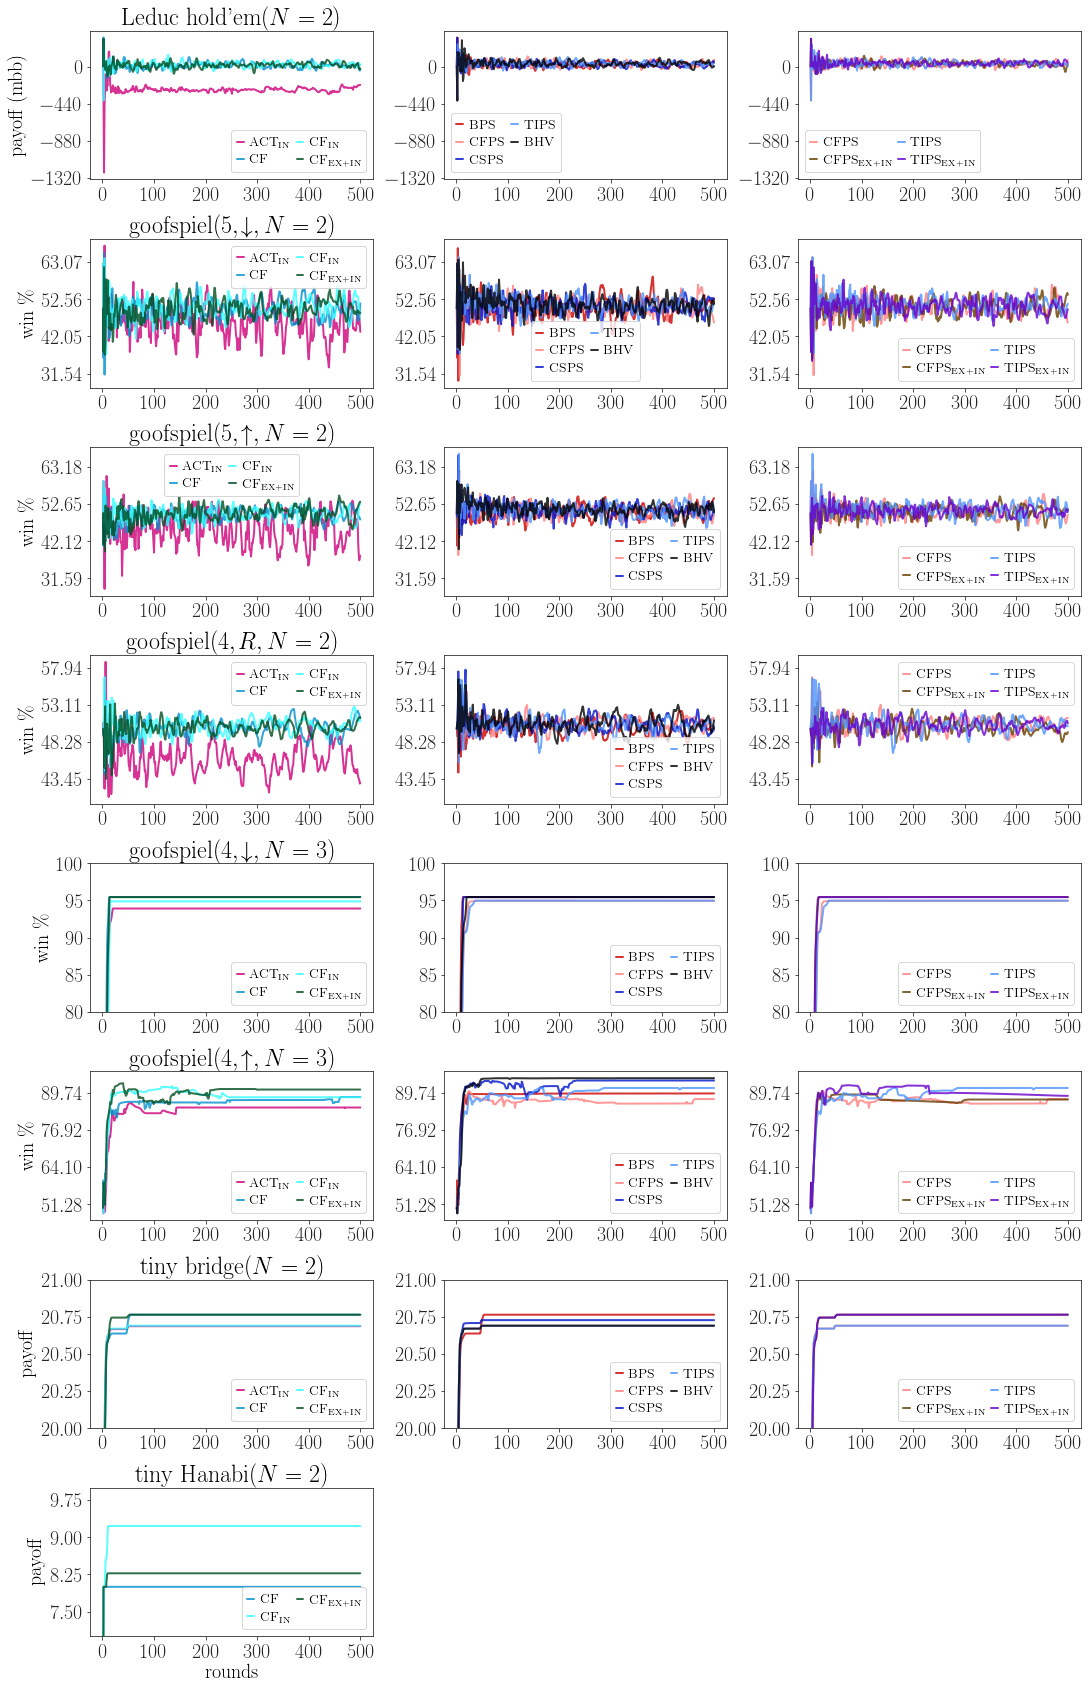

In [42]:
ylim_by_game = {
    'goofspiel_3p': (80, 100),
    'tiny_bridge': (20, 21),
    'tiny_hanabi': (7, 10),
}

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='sim',
                    algs=alg_group,
                    col_algs=list(all_algs))),
            False)
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j, avg=False)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j, avg=False)
        elif j == 0:
            ax.set_ylabel(inst_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'results/learning_curves.sim.inst.{date}.pdf')

In [43]:
# plt.figure(figsize=(10, 3))
# mcd_tournament.heatmap(
#     mcd_tournament.without_br_row(data.fixed_table('kuhn_3p')),
#     cmap=div_color_palette
# )

In [12]:
# for seed in data.all_seeds():
#     if not np.isnan(seed):
#         plt.figure(figsize=(10, 3))
#         mcd_tournament.heatmap(
#             mcd_tournament.without_br_row(
#                 data.shuffled_table('kuhn_3p', seed)) * 1000,
#             cmap=div_color_palette)
#         plt.show()

In [13]:
# (data.shuffled_table_by_seed("kuhn_3p") * 1000).std().max()

In [14]:
# (data.max_abs_diff_from_mean("kuhn_3p") * 1000).max()

In [15]:
# _df = data.time_avg_sim_table('tiny_hanabi', 200).query('row_alg == ["CFR", "FP"] & col_alg == ["CFR"]')

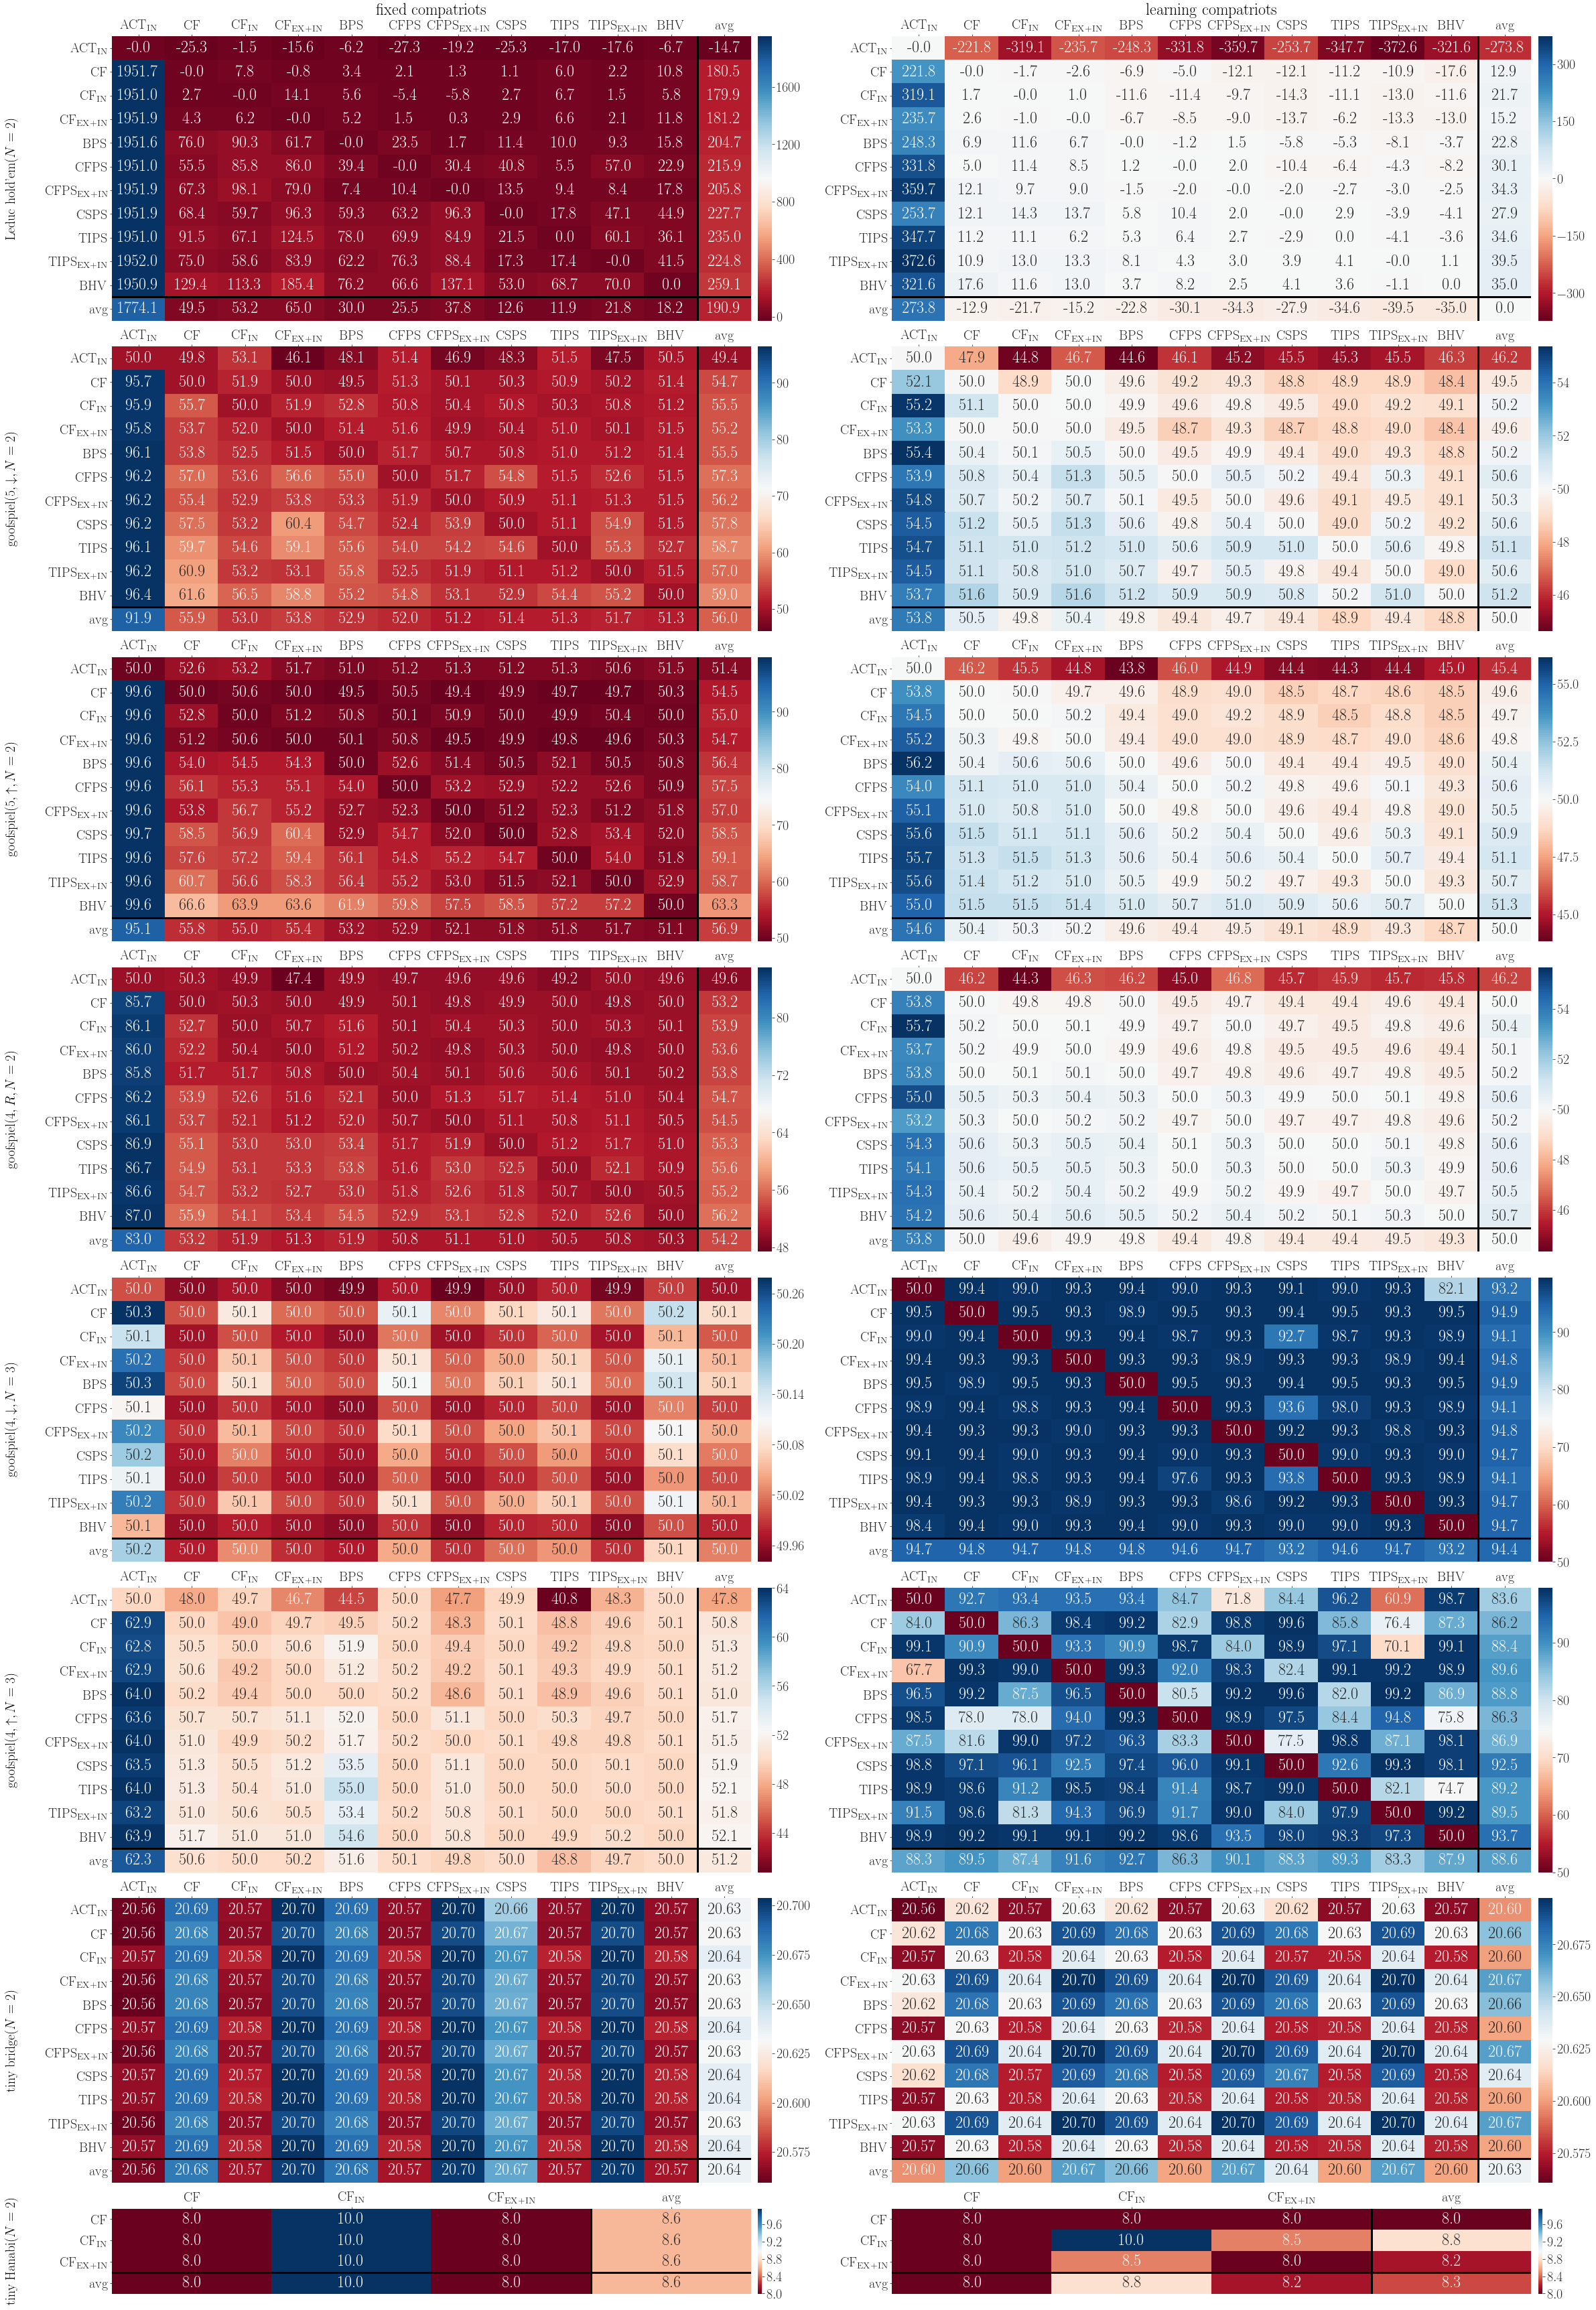

In [52]:
num_rounds = 501
num_cols = 2
games = data.games()
num_games1 = len(games)
# num_games1 = int(np.ceil(num_games1 / 2))
fig, axes_list = plt.subplots(
    num_games1,
    num_cols + 1,
    squeeze=False,
    figsize=(33, 6 * num_games1),
    gridspec_kw={'width_ratios': [0.01, 1, 1], 'height_ratios': [1, 1, 1, 1, 1, 1, 1, 0.3]})
axes_list[0, 1].set_title('fixed compatriots')
axes_list[0, 2].set_title('learning compatriots')

# num_games2 = int(np.floor(len(games) / 2))
# fig2, axes_list2 = plt.subplots(
#     num_games2,
#     num_cols + 1,
#     squeeze=False,
#     figsize=(33, 6 * num_games2),
#     gridspec_kw={'width_ratios': [0.01, 1, 1], 'height_ratios': [1, 1, 1, 0.3]})
# axes_list2[0, 1].set_title('fixed regime')
# axes_list2[0, 2].set_title('simultaneious regime')
# axes_list = np.concatenate([axes_list, axes_list2], axis=0)
for i, game in enumerate(games):
    axes_list[i, 2].sharex(axes_list[i, 1])
    axes_list[i, 2].sharey(axes_list[i, 1])
#     axes_list[i, 2].yaxis.set_visible(False)

    if game == 'tiny_hanabi':
        _df = data.data.query(
            ' & '.join([
                f'game_tag == "{game}"',
                'mode == "fixed"',
                f't < {num_rounds}',
                f'row_alg == {list(nf_algs)}',
                f'col_alg == {list(nf_algs)}',
            ]))
        _df = _df.pivot(index='t', columns=['row_alg', 'col_alg'],
                        values='value').mean().unstack()
    else:
        _df = mcd_tournament.without_br_row(data.time_avg_fixed_table(game, num_rounds))
        
    fmt = "0.1f"
    if is_leduc(game):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game):
        _df = goofspiel_score_to_win_percentage(_df)
        fmt = "0.1f"
    elif game == 'tiny_bridge':
        fmt = "0.2f"
    
    mcd_tournament.heatmap(
        _df,
        fmt=fmt,
        ax=axes_list[i, 1],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    if game == 'tiny_hanabi':
        _df = data.data.query(
            ' & '.join([
                f'game_tag == "{game}"',
                'mode == "sim"',
                f't < {num_rounds}',
                f'row_alg == {list(nf_algs)}',
                f'col_alg == {list(nf_algs)}',
            ]))
        _df = _df.pivot(index='t', columns=['row_alg', 'col_alg'],
                        values='value').mean().unstack()
    else:
        _df = data.time_avg_sim_table(game, num_rounds)
    if is_leduc(game):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game):
        _df = goofspiel_score_to_win_percentage(_df)
    
    mcd_tournament.heatmap(
        _df,
        fmt=fmt,
        ax=axes_list[i, 2],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    axes_list[i, 0].axis('off')
    axes_list[i, 0].text(0, 0.5, mcd_tournament.game_label(game),
                         horizontalalignment='left',
                         verticalalignment='center',
                         rotation=90,
                         transform=axes_list[i, 0].transAxes)
fig.tight_layout(pad=0.1)
fig.subplots_adjust(wspace=0.22, hspace=0.1)
fig.savefig(f'results/heatmaps.{date}.pdf')
# fig2.tight_layout(pad=0.1)
# fig2.subplots_adjust(wspace=0.22, hspace=0.15)
# fig2.savefig(f'results/heatmaps.{date}-2.pdf')

In [ ]:
# fig, axes_list = plt.subplots(
#     2,
#     1,
#     sharex=True,
#     sharey=True,
#     squeeze=True,
#     figsize=(13.5, 3.5 * 3))
# mcd_tournament.heatmap_avg(
#     mcd_tournament.without_br_row(data.fixed_avg_table()),
#     ax=axes_list[0],
#     cmap=div_color_palette,
#     cbar_kws={'fraction': 0.05, 'pad': 0.01},
#     fmt="0.3f"
# )
# # mcd_tournament.heatmap_avg(
# #     mcd_tournament.without_br_row(data.shuffled_avg_table()),
# #     ax=axes_list[1],
# #     cmap=div_color_palette,
# #     cbar_kws={'fraction': 0.05, 'pad': 0.01},
# #     fmt="0.3f"
# # )
# mcd_tournament.heatmap_avg(
#     mcd_tournament.without_br_row(data.sim_avg_table()),
#     ax=axes_list[1],
#     cmap=div_color_palette,
#     cbar_kws={'fraction': 0.05, 'pad': 0.01},
#     fmt="0.3f"
# )
# plt.tight_layout(0)
# plt.subplots_adjust(hspace=0.25)
# fig.savefig(f'results/avg_heatmaps.aug22_2020.pdf')
# plt.show()

In [ ]:
_algs = [
    'A-CFR_IN',
    'CFR',
    'CFR_IN',
    'BPS-CFR',
    'CFPS-CFR',
    'CSPS-CFR',
    'TIPS-CFR',
    'BEHAV-CFR',
]
_alg_label_map = {
    'CFR': r'\textsc{cf}',
    'CFR_IN': r'\textsc{cf}\textsubscript{\INT}',
    'A-CFR_IN': r'\textsc{act}\textsubscript{\INT}',
    'CSPS-CFR': r'\textsc{csps}',
    'CFPS-CFR': r'\textsc{cf}',
    'TIPS-CFR': r'\textsc{tips}',
    'BPS-CFR': r'\textsc{bps}',
    'BEHAV-CFR': r'\textsc{bhv}',
}

def alg_labels(alg_tags):
    return [
      _alg_label_map[tag]
      for tag in alg_tags
    ]

def alg_sort_key(tag):
  return _algs.index(tag)


def alg_sort_keys(tags):
  return pd.Index([alg_sort_key(tag) for tag in tags], name=tags.name)


def with_sorted_algs(df):
  return df.sort_index(axis=0, key=alg_sort_keys)

In [ ]:
fmt = r'{:.0%}\%'
num_rounds = 500

In [ ]:
_game_tags = [
    'goofspiel_ascending',
    'goofspiel_ascending_3p',
]
_modes = [
    'fixed',
    'sim',
]
_qs = ' & '.join(
    [
        f'game_tag == {list(_game_tags)}',
        f'mode == {list(_modes)}',
        f't < {num_rounds}',
        f'row_alg == {list(_algs)}',
        f'col_alg == {list(_algs)}'
    ]
)
_df = data.data.query(_qs)
_df = _df.pivot(
    index=['t', 'col_alg'],
    columns=['row_alg', 'mode', 'game_tag'],
    values='value'
).mean().unstack(level=[1, 2])
_df = with_sorted_algs(_df)
_df = _df.sort_index(axis='columns', level=1, key=(
    lambda x: pd.Index([_game_tags.index(y) for y in x], name=x.name)
))
_df = goofspiel_score_to_win_percentage(_df)
_df.index = pd.Index(alg_labels(_df.index))
print(_df.to_string(
    formatters=(
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
    )
))

In [ ]:
_df = goofspiel_score_to_win_percentage(
    data.time_avg_fixed_table(
    'goofspiel_ascending_3p', num_rounds).mean(axis=1))
_df = _df.map(fmt.format)
_df = _df[_row_alg]
print('# Fixed, gThreeFour')
print(f'# {_row_alg}')
print(_df)

In [ ]:
_df = goofspiel_score_to_win_percentage(
    data.time_avg_sim_table(
    'goofspiel_ascending', num_rounds).mean(axis=1))
_df = _df.map(fmt.format)
_df = _df[_row_alg]
print('# Sim, gTwoFive')
print(f'# {_row_alg}')
print(_df)

In [ ]:
_df = goofspiel_score_to_win_percentage(
    data.time_avg_sim_table(
    'goofspiel_ascending_3p', num_rounds).mean(axis=1))
_df = _df.map(fmt.format)
_df = _df[_row_alg]
print('# Sim, gThreeFour')
print(f'# {_row_alg}')
print(_df)